In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [3]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [4]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [5]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)

In [6]:
# Aggregating settlement location for system-wide data
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [7]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)

In [8]:
# Aggregating settlement location for system-wide data
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 01:00:00,01/01/2018 01:00:00,37.390157,2018-01-01,01:00:00,01:00:00,True,1,1,60
01/01/2018 02:00:00,01/01/2018 02:00:00,37.249877,2018-01-01,02:00:00,02:00:00,True,1,1,120
01/01/2018 03:00:00,01/01/2018 03:00:00,37.998882,2018-01-01,03:00:00,03:00:00,True,1,1,180
01/01/2018 04:00:00,01/01/2018 04:00:00,40.778408,2018-01-01,04:00:00,04:00:00,True,1,1,240
01/01/2018 05:00:00,01/01/2018 05:00:00,42.051515,2018-01-01,05:00:00,05:00:00,True,1,1,300


In [9]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d

In [10]:
# Merging RT, DA and Load data
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time'})

In [11]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

In [12]:
# Opening and concatenating DA Load datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA Load\2018'
DA_path = 'DA-MC-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA_load_2018 = pd.concat(dfs)

In [13]:
# Merging Forecast Load to dataset
DA_load_2018.index = DA_load_2018['Interval']
comparison = DA_load_2018.iloc[:,8:9].join(DART_gen_2018,how='right')
DART2018 = filler(comparison, ' Total Demand')
DART2018 = DART2018.iloc[11:,:]
DART2018 = DART2018.rename(columns={' Total Demand':'DA Load'})
DART2018['Load_Diff'] = DART2018['Load'] - DART2018['DA Load']

In [14]:
DART2018['Spread'] = DART2018['LMP_DA'] - DART2018['LMP_RT']

In [15]:
# Adding previous-interval and moving averages
DART2018_1 = DART2018.iloc[1:,:]
previous_load_diff = DART2018['Load_Diff'].iloc[0:-1].values
DART2018_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2018['LMP_RT'].iloc[0:-1].values
DART2018_1['Previous_RT'] = previous_RT

previous_spread = DART2018['Spread'].iloc[0:-1].values
DART2018_1['Previous_Spread'] = previous_spread

step = 3
previous_RT = DART2018_1['LMP_RT'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2018_1['Load_Diff'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2018_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2018_2 = DART2018_1.iloc[step:,:]
DART2018_2['Previous_RT_2'] = previous_means_RT
DART2018_2['Previous_Load_Diff_2'] = previous_means_load

DART2018_2.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,DA Load,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,...,Month,Day,Minute of Day,Load_Diff,Spread,Previous_Load_Diff,Previous_RT,Previous_Spread,Previous_RT_2,Previous_Load_Diff_2
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 01:20:00,36085.6,2018-01-01T07:20:00Z,2991.5,18157.5,0.0,0.0,43.7,486.7,6054.3,2961.2,...,1,1,80,-0.286,12.660533,4.404,24.118414,13.271743,27.302014,18.136000
01/01/2018 01:25:00,36085.6,2018-01-01T07:25:00Z,3000.8,18190.0,0.0,0.0,43.8,486.1,6031.1,2948.6,...,1,1,85,21.518,9.001005,-0.286,24.729624,12.660533,26.031712,8.197667
01/01/2018 01:30:00,36085.6,2018-01-01T07:30:00Z,3003.2,18246.4,0.0,0.0,43.5,486.4,6089.9,2958.0,...,1,1,90,-8.024,9.122246,21.518,28.389152,9.001005,25.745730,8.545333
01/01/2018 01:35:00,36085.6,2018-01-01T07:35:00Z,3004.7,18273.8,0.0,0.0,43.1,486.0,6142.3,2938.2,...,1,1,95,-36.888,4.520928,-8.024,28.267911,9.122246,27.128896,4.402667
01/01/2018 01:40:00,36085.6,2018-01-01T07:40:00Z,3008.3,18229.0,0.0,0.0,43.9,486.9,6171.6,2894.4,...,1,1,100,-102.888,6.907351,-36.888,32.869229,4.520928,29.842097,-7.798000


In [19]:
# comparing features

np.seterr(divide='print',invalid='print')

n = 10
PE_11_list = []
PE_10_list = []
errors = 0

for i in range(n):
    for j in range(1,13):
        by_month = DART2018_2[DART2018_2['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2', 'Previous_Spread']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2', 'Previous_Spread']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (11)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result11 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_Spread + Load_Diff + 
                                    Previous_Load_Diff + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + 
                                    Previous_Load_Diff + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for hour in cluster.index:
                    test_data_copy['fitted RT (11)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result11.params[11] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result11.params[10] +  
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result11.params[9] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result11.params[8] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result11.params[7] + 
                                                test_data_copy['Previous_Spread'].loc[hour]*result11.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result11.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result11.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result11.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result11.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result11.params[1] + 
                                                result11.params[0])
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_11_list.append(pe(test_data_copy['fitted RT (11)'], test_data_copy['LMP_RT']).mean())
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{10*i}%',end='')

PE_11_array = np.array(PE_11_list)
PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('11 predictors: {} \u00B1 {}'.format(PE_11_array.mean(), PE_11_array.std()))
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))

90%
MAPE ± std
11 predictors: 9.961898556378953 ± 3.4616992661967707
10 predictors: 9.70788025480528 ± 3.179429108537624
# of errors: 0


Of course, we can't add spread as a feature. But it was an interesing test to see how smf cleverly reads the data.

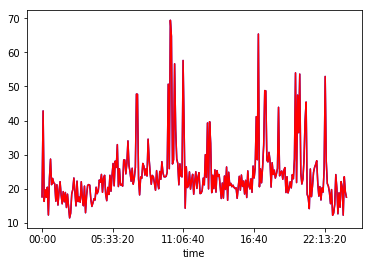

In [92]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (11)'], 'blue')
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red')

Let's only train and test weekdays.

In [35]:
weekdays = DART2018_2[DART2018_2['Weekday']==True]

In [66]:

np.seterr(divide='print',invalid='print')

n = 100
PE_10_list = []
errors = 0

df = DART2018_2

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for var in result10.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result10.params.loc[var])
                    else:
                        slopes[var].append(result10.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))
means_dict(slopes)

100.0%
MAPE ± std
10 predictors: 7.621880664095494 ± 2.7088948345626935
# of errors: 0


{'Intercept': -2.6298806639117753,
 'LMP_DA': 0.10413376129412183,
 'RT_std': 0.12368789896224562,
 'DA_std': -0.11808788191445188,
 'Load': 0.0007176196802416501,
 'Wind': -0.0007346828878633668,
 'Load_Diff': -8.916364511277414e-05,
 'Previous_Load_Diff': 0.0017346108558660138,
 'Previous_Load_Diff_2': -0.0008663898449060166,
 'Previous_RT': 0.17799284955442535,
 'Previous_RT_2': 0.12304301143408031}

In [68]:
print('result: {} \u00B1 {}'.format(PE_10_array.mean(), stats.sem(PE_10_array)))

result: 7.621880664095494 ± 0.07823166141642192


In [17]:
def means_std_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = [np.array(d[key]).mean(),stats.sem(np.array(d[key]))]
    return means_d

In [70]:
means_std_dict(slopes)

{'Intercept': [-2.6298806639117753, 1.4321046626058493],
 'LMP_DA': [0.10413376129412183, 0.03846126854698665],
 'RT_std': [0.12368789896224562, 0.004101857278836036],
 'DA_std': [-0.11808788191445188, 0.04108658724415985],
 'Load': [0.0007176196802416501, 0.00010211894160358987],
 'Wind': [-0.0007346828878633668, 8.181987584418869e-05],
 'Load_Diff': [-8.916364511277414e-05, 0.00012271730182204007],
 'Previous_Load_Diff': [0.0017346108558660138, 0.0001666963999937584],
 'Previous_Load_Diff_2': [-0.0008663898449060166, 0.00013211040559498168],
 'Previous_RT': [0.17799284955442535, 0.007236901312747004],
 'Previous_RT_2': [0.12304301143408031, 0.025234555444115528]}

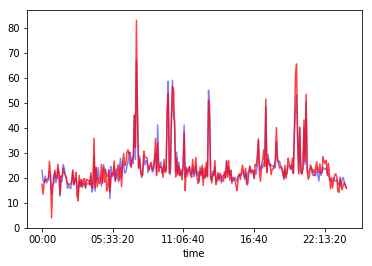

In [45]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (10)'], 'blue', alpha=0.5)
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red', alpha=0.75)

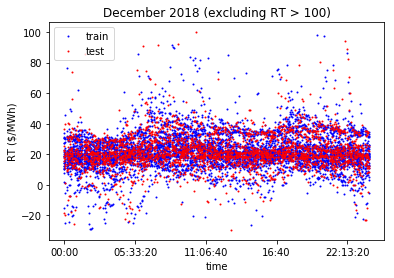

In [47]:
plt.plot(train[train['LMP_RT']<100]['Local Time'], train[train['LMP_RT']<100]['LMP_RT'], 'bo', ms=1, label='train')
plt.plot(test[test['LMP_RT']<100]['Local Time'], test[test['LMP_RT']<100]['LMP_RT'], 'ro', ms=1, label='test')
plt.title('December 2018 (excluding RT > 100)')
plt.ylabel('RT ($/MWh)')
plt.legend()

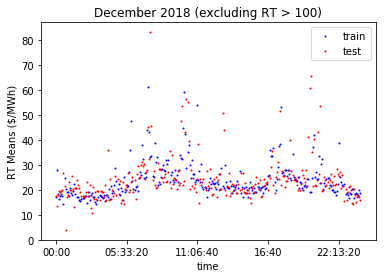

In [20]:
plt.plot(train_data[train_data['LMP_RT']<100].index, train_data[train_data['LMP_RT']<100]['LMP_RT'], 'bo', ms=1, label='train')
plt.plot(test_data[test_data['LMP_RT']<100].index, test_data[test_data['LMP_RT']<100]['LMP_RT'], 'ro', ms=1, label='test')
plt.title('December 2018 (excluding RT > 100)')
plt.ylabel('RT Means ($/MWh)')
plt.legend()

All data
test size = 0.33 -> MAPE = 10.0
test size = 0.4 -> MAPE = 8.5
test size = 0.5 -> MAPE = 7.5
test size = 0.75 -> MAPE = 9.4

Weekdays
test size = 0.33 -> MAPE = 12.9
test size = 0.4 -> MAPE = 9.8
test size = 0.5 -> MAPE = 8.3
test size = 0.75 -> MAPE = 10.6

Text(100, 80, 'MAPE = 9.4')

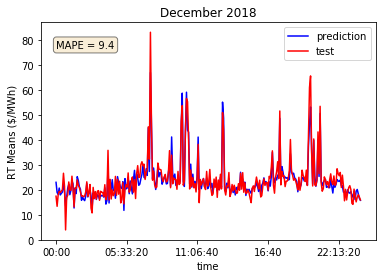

In [53]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (10)'], 'blue', label='prediction')
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red', label='test')
plt.legend()
plt.title('December 2018')
plt.ylabel('RT Means ($/MWh)')
plt.text(100,80,'MAPE = 9.4',horizontalalignment='left',verticalalignment='top',bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

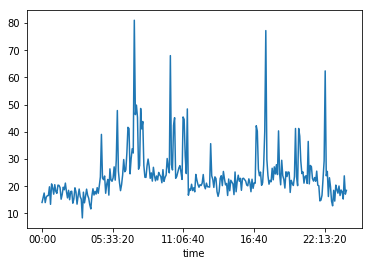

In [59]:
plt.plot(train_data[train_data['LMP_RT']<100].index,train_data[train_data['LMP_RT']<100]['LMP_RT'])

In [16]:
# 2017 data

SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'
RT_path = '\\RT\\2017\\LMP_SL_2017.csv'
DA_path = '\\DA\\2017\\LMP_SL_2017.csv'
RT_2017 = pd.read_csv(SPP_path + RT_path)
print('Loaded RT data')
DA_2017 = pd.read_csv(SPP_path + DA_path)
print('Loaded DA data')

Loaded RT data
Loaded DA data


In [18]:
RT2017_aggloc = RT_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                      'LMP':'mean'})
RT2017_aggloc = add_info(RT2017_aggloc)
RT2017_aggloc.head()

,INTERVAL,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
INTERVAL,,,,,,,,,
2017-01-01 00:05:00.000000,2017-01-01 00:05:00.000000,16.911322,2017-01-01,00:05:00,00:00:00,False,1,1,5
2017-01-01 00:10:00.000000,2017-01-01 00:10:00.000000,17.264418,2017-01-01,00:10:00,00:00:00,False,1,1,10
2017-01-01 00:15:00.000000,2017-01-01 00:15:00.000000,16.422609,2017-01-01,00:15:00,00:00:00,False,1,1,15
2017-01-01 00:20:00.000000,2017-01-01 00:20:00.000000,21.653247,2017-01-01,00:20:00,00:00:00,False,1,1,20
2017-01-01 00:25:00.000000,2017-01-01 00:25:00.000000,18.293177,2017-01-01,00:25:00,00:00:00,False,1,1,25


In [19]:
DA2017_aggloc = DA_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                    'LMP':'mean'})
DA2017_aggloc = add_info(DA2017_aggloc)
DA2017_aggloc.head()

,INTERVAL,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
INTERVAL,,,,,,,,,
2017-01-01 01:00:00.000000,2017-01-01 01:00:00.000000,21.983863,2017-01-01,01:00:00,01:00:00,False,1,1,60
2017-01-01 02:00:00.000000,2017-01-01 02:00:00.000000,20.761607,2017-01-01,02:00:00,02:00:00,False,1,1,120
2017-01-01 03:00:00.000000,2017-01-01 03:00:00.000000,19.944763,2017-01-01,03:00:00,03:00:00,False,1,1,180
2017-01-01 04:00:00.000000,2017-01-01 04:00:00.000000,20.188906,2017-01-01,04:00:00,04:00:00,False,1,1,240
2017-01-01 05:00:00.000000,2017-01-01 05:00:00.000000,20.363023,2017-01-01,05:00:00,05:00:00,False,1,1,300


In [20]:
gen_mix_2017 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')
list_intervals = gen_mix_2017[gen_mix_2017.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2017['Local Date'] = np.array(local_date)
gen_mix_2017['Local Time'] = np.array(local_time)
gen_mix_2017.head()

,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,Wind,Waste Heat,Other,Average Actual Load,Local Date,Local Time
0,2017-01-01T06:00:00Z,2956.2,13385.3,0.0,251.8,3025.9,2098.4,0.0,7.7,4499.1,0.0,35.4,25380.548,2017-01-01,00:00:00
1,2017-01-01T06:05:00Z,2920.2,13342.3,0.0,241.7,2988.6,2100.8,0.0,8.1,4529.3,0.0,35.7,25356.102,2017-01-01,00:05:00
2,2017-01-01T06:10:00Z,2920.2,13254.2,0.0,241.7,2969.2,2100.8,0.0,8.1,4529.3,0.0,35.7,25356.102,2017-01-01,00:10:00
3,2017-01-01T06:15:00Z,2923.2,13380.3,0.0,267.6,2981.2,2099.1,0.0,8.1,4551.8,0.0,35.7,25358.945,2017-01-01,00:15:00
4,2017-01-01T06:20:00Z,2900.3,13388.1,0.0,276.7,2960.1,2099.8,0.0,8.7,4603.1,0.0,36.4,25345.252,2017-01-01,00:20:00


In [21]:
# Merging RT, DA and Load data
comparison = DA2017_aggloc.iloc[:,1:2].join(RT2017_aggloc,how='right',lsuffix='_DA',rsuffix='_RT')
DART2017_5min = filler(comparison, 'LMP_DA')
new_index = []
for i in range(DART2017_5min.shape[0]):
    new_index.append(DART2017_5min['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + DART2017_5min['Local Time'].iloc[i].strftime("%H:%M:%S"))
DART2017_5min.index = np.array(new_index)
DART2017_5min.head()

,LMP_DA,INTERVAL,LMP_RT,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
01/01/2017 00:05:00,0.0,2017-01-01 00:05:00.000000,16.911322,2017-01-01,00:05:00,00:00:00,False,1,1,5
01/01/2017 00:10:00,0.0,2017-01-01 00:10:00.000000,17.264418,2017-01-01,00:10:00,00:00:00,False,1,1,10
01/01/2017 00:15:00,0.0,2017-01-01 00:15:00.000000,16.422609,2017-01-01,00:15:00,00:00:00,False,1,1,15
01/01/2017 00:20:00,0.0,2017-01-01 00:20:00.000000,21.653247,2017-01-01,00:20:00,00:00:00,False,1,1,20
01/01/2017 00:25:00,0.0,2017-01-01 00:25:00.000000,18.293177,2017-01-01,00:25:00,00:00:00,False,1,1,25


In [22]:
gen_2017 = gen_mix_2017
new_index = []
for i in range(gen_2017.shape[0]):
    new_index.append(gen_2017['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2017['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2017.index = np.array(new_index)
DART_gen_2017 = gen_2017.join(DART2017_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2017.tail()

,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,Wind,...,LMP_DA,INTERVAL,LMP_RT,Local Date_price,Local Time_price,Hour,Weekday,Month,Day,Minute of Day
12/31/2017 23:40:00,2018-01-01T05:40:00Z,2946.7,18733.8,4.4,794.6,8674.2,2034.5,0.0,11.0,3817.7,...,43.236809,2017-12-31 23:40:00.000000,33.915670,2017-12-31,23:40:00,23:00:00,False,12,31,1420
12/31/2017 23:45:00,2018-01-01T05:45:00Z,2943.9,18774.4,4.4,734.3,8678.3,2034.4,0.0,11.0,3730.8,...,43.236809,2017-12-31 23:45:00.000000,31.556102,2017-12-31,23:45:00,23:00:00,False,12,31,1425
12/31/2017 23:50:00,2018-01-01T05:50:00Z,2946.8,18795.1,4.4,733.4,8692.2,2033.3,0.0,10.9,3709.5,...,43.236809,2017-12-31 23:50:00.000000,33.072190,2017-12-31,23:50:00,23:00:00,False,12,31,1430
12/31/2017 23:55:00,2018-01-01T05:55:00Z,2952.1,18232.8,4.4,798.0,9186.7,2034.4,0.0,10.8,3718.2,...,43.236809,2017-12-31 23:55:00.000000,33.519099,2017-12-31,23:55:00,23:00:00,False,12,31,1435
01/01/2018 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.699045,2018-01-01 00:00:00.000000,251.014564,2018-01-01,00:00:00,00:00:00,True,1,1,0


In [23]:
DART_gen_2017 = DART_gen_2017.rename(columns={' Average Actual Load':'Load',
                                             'Wind':'Wind',
                                             'Local Time_price':'Local Time'})

In [24]:
# Opening and concatenating DA Load datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA Load\2017'
DA_path = 'DA-MC-2017'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA_load_2017 = pd.concat(dfs)

In [25]:
# Merging Forecast Load to dataset
DA_load_2017.index = DA_load_2017['Interval']
comparison = DA_load_2017.iloc[:,8:9].join(DART_gen_2017,how='right')
DART2017 = filler(comparison, ' Total Demand')
DART2017 = DART2017.iloc[11:,:]
DART2017 = DART2017.rename(columns={' Total Demand':'DA Load'})
DART2017['Load_Diff'] = DART2017['Load'] - DART2017['DA Load']
DART2017['Spread'] = DART2017['LMP_DA'] - DART2017['LMP_RT']

In [26]:
# Adding previous-interval and moving averages
DART2017_1 = DART2017.iloc[1:,:]
previous_load_diff = DART2017['Load_Diff'].iloc[0:-1].values
DART2017_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2017['LMP_RT'].iloc[0:-1].values
DART2017_1['Previous_RT'] = previous_RT
previous_spread = DART2017['Spread'].iloc[0:-1].values
DART2017_1['Previous_Spread'] = previous_RT

step = 3
previous_RT = DART2017_1['LMP_RT'].iloc[0:(DART2017_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2017_1['Load_Diff'].iloc[0:(DART2017_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2017_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2017_2 = DART2017_1.iloc[step:,:]
DART2017_2['Previous_RT_2'] = previous_means_RT
DART2017_2['Previous_Load_Diff_2'] = previous_means_load
DART2017_2 = DART2017_2.rename(columns={' Wind':'Wind'})


DART2017_2.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,DA Load,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,...,Month,Day,Minute of Day,Load_Diff,Spread,Previous_Load_Diff,Previous_RT,Previous_Spread,Previous_RT_2,Previous_Load_Diff_2
01/01/2017 01:20:00,26057.9,2017-01-01T07:20:00Z,2739.1,13144.9,0.0,277.0,2828.2,2098.9,0.0,10.9,...,1,1,80,-677.096,1.897070,-610.435,18.591515,18.591515,17.339346,-584.390667
01/01/2017 01:25:00,26057.9,2017-01-01T07:25:00Z,2727.2,13110.1,0.0,276.9,2769.1,2097.0,0.0,11.0,...,1,1,85,-707.379,2.889182,-677.096,20.086793,20.086793,18.989869,-620.560000
01/01/2017 01:30:00,26057.9,2017-01-01T07:30:00Z,2715.5,13074.0,0.0,278.5,2738.7,2098.9,0.0,11.2,...,1,1,90,-743.814,2.989947,-707.379,19.094681,19.094681,19.257663,-664.970000
01/01/2017 01:35:00,26057.9,2017-01-01T07:35:00Z,2704.8,13054.3,0.0,277.0,2717.0,2098.6,0.0,11.1,...,1,1,95,-777.194,3.318540,-743.814,18.993916,18.993916,19.391797,-709.429667
01/01/2017 01:40:00,26057.9,2017-01-01T07:40:00Z,2679.5,13035.3,0.0,278.2,2757.6,2097.7,0.0,11.3,...,1,1,100,-806.646,3.516765,-777.194,18.665323,18.665323,18.917974,-742.795667


In [27]:
DART = pd.concat([DART2017_2, DART2018_2])
DART.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Coal Market,Coal Self,Diesel Fuel Oil,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Gas Self,Hydro,Hydro Market,Hydro Self,Natural Gas,...,Minute of Day,Month,Previous_Load_Diff,Previous_Load_Diff_2,Previous_RT,Previous_RT_2,Previous_Spread,Spread,Weekday,Wind
01/01/2017 01:20:00,2739.1,13144.9,0.0,NaN,NaN,NaN,277.0,NaN,NaN,2828.2,...,80,1,-610.435,-584.390667,18.591515,17.339346,18.591515,1.897070,False,5214.0
01/01/2017 01:25:00,2727.2,13110.1,0.0,NaN,NaN,NaN,276.9,NaN,NaN,2769.1,...,85,1,-677.096,-620.560000,20.086793,18.989869,20.086793,2.889182,False,5293.3
01/01/2017 01:30:00,2715.5,13074.0,0.0,NaN,NaN,NaN,278.5,NaN,NaN,2738.7,...,90,1,-707.379,-664.970000,19.094681,19.257663,19.094681,2.989947,False,5312.4
01/01/2017 01:35:00,2704.8,13054.3,0.0,NaN,NaN,NaN,277.0,NaN,NaN,2717.0,...,95,1,-743.814,-709.429667,18.993916,19.391797,18.993916,3.318540,False,5367.3
01/01/2017 01:40:00,2679.5,13035.3,0.0,NaN,NaN,NaN,278.2,NaN,NaN,2757.6,...,100,1,-777.194,-742.795667,18.665323,18.917974,18.665323,3.516765,False,5333.2


In [28]:
# Testing for 2 years for the 1st time

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
errors = 0

df = DART

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for var in result10.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result10.params.loc[var])
                    else:
                        slopes[var].append(result10.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))
means_std_dict(slopes)

100.0%
MAPE ± std
10 predictors: 7.248259895989084 ± 2.6475743734563193
# of errors: 0


{'Intercept': [-8.953130752992756, 1.572197579417522],
 'LMP_DA': [0.03316700793475445, 0.03146773943619429],
 'RT_std': [0.12410431339821075, 0.009098622156542948],
 'DA_std': [-0.10518138234787229, 0.046038956507764336],
 'Load': [0.0009014963338839786, 0.00010807922515469344],
 'Wind': [-0.0008322671975098912, 0.00015680197259710814],
 'Load_Diff': [-0.00046677442904373314, 0.0005764761569878965],
 'Previous_Load_Diff': [0.0015360398212434095, 0.000648527999564579],
 'Previous_Load_Diff_2': [-0.0007315404828339893, 0.0006467686833625179],
 'Previous_RT': [0.1761910303523444, 0.012891527562160289],
 'Previous_RT_2': [0.16032667277176707, 0.013938732825533746]}

In [41]:
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), stats.sem(PE_10_array)))

10 predictors: 6.590666382778563 ± 0.0725754736821259


In [29]:
# Reducing # of predictors 

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
PE_8_list = []
errors = 0

df = DART

slopes_10 = {}
slopes_8 = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (8)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                
                for var in result10.params.index:
                    if var not in slopes_10.keys():
                        slopes_10[var] = []
                        slopes_10[var].append(result10.params.loc[var])
                    else:
                        slopes_10[var].append(result10.params.loc[var])
                for var in result8.params.index:
                    if var not in slopes_8.keys():
                        slopes_8[var] = []
                        slopes_8[var].append(result8.params.loc[var])
                    else:
                        slopes_8[var].append(result8.params.loc[var])                
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
                    test_data_copy['fitted RT (8)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[9] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result8.params[8] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result8.params[7] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result8.params[6] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Wind'].loc[hour]*result8.params[4] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[3] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        PE_8_list.append(pe(test_data_copy['fitted RT (8)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)
PE_8_array = np.array(PE_8_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('9 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('# of errors: {}'.format(errors))

100.0%
MAPE ± std
10 predictors: 9.82426153060818 ± 23.024567724595443
9 predictors: 17.98388265525072 ± 17.251657180263418
# of errors: 0


In [30]:
means_std_dict(slopes_10)

{'Intercept': [-7.021124305781938, 1.885426440916502],
 'LMP_DA': [-0.03843914293696612, 0.04295941193359635],
 'RT_std': [0.12203764623791089, 0.009814861169863942],
 'DA_std': [-0.1353351052658648, 0.04510895332607952],
 'Load': [0.0010183568888058143, 9.990657781800177e-05],
 'Wind': [-0.0008219036714964712, 0.00011053001361404208],
 'Load_Diff': [-2.8638416126660408e-05, 0.00016913976604228297],
 'Previous_Load_Diff': [0.0013899364233049022, 0.0002088793008179749],
 'Previous_Load_Diff_2': [-0.00046738486455781813, 0.00018657976068135073],
 'Previous_RT': [0.12515896434950013, 0.00866013692089452],
 'Previous_RT_2': [0.09033668866761256, 0.011758616182223243]}

In [31]:
means_std_dict(slopes_8)

{'Intercept': [-10.805573480661756, 11.79956398775916],
 'LMP_DA': [-0.8396364540343486, 0.36251609401281987],
 'DA_std': [-0.25660700137757947, 0.4859032975443768],
 'Load': [0.002025609962022444, 0.0007279482656095425],
 'Wind': [-0.0006907195625544283, 0.0007358574471150302],
 'Load_Diff': [0.0022078641847404754, 0.002219904960600083],
 'Previous_Load_Diff': [0.001601956031100843, 0.00041863473970138936],
 'Previous_Load_Diff_2': [0.00016433440396554713, 0.0004836577320882233],
 'Previous_RT': [0.31834335800821356, 0.0795258822189969],
 'Previous_RT_2': [0.0710168907715142, 0.11440108075235508]}

Eliminating RT_std and RT_Load_Diff deteriorates the model by 8 % pts (from 7 to 15%); it also changes load slope.
Test was repeated for test-size of .33 and didn't change much.

In [40]:
clean = DART[(DART['Load']>10000)&(DART['LMP_RT']<200)]

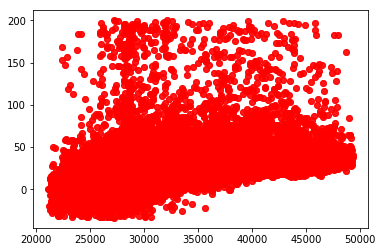

In [41]:
plt.plot(clean['Load'],clean['LMP_RT'],'ro',alpha=0.7)

In [50]:
weekdays = DART[DART['Weekday']==True]
weekends = DART[DART['Weekday']==False]

In [52]:
# Testing weekday vs weekend

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
errors = 0

df = weekends

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for var in result10.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result10.params.loc[var])
                    else:
                        slopes[var].append(result10.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))
means_std_dict(slopes)

100.0%
MAPE ± std
10 predictors: 14.081149379140944 ± 19.759961751889364
# of errors: 0


{'Intercept': [0.20819019497306274, 4.038619330362585],
 'LMP_DA': [0.14028496778213395, 0.07943673894358128],
 'RT_std': [0.13350590916085017, 0.020402852065126348],
 'DA_std': [-0.06790798297538535, 0.08582026449771078],
 'Load': [0.0006864868558669536, 0.0002636746678368859],
 'Wind': [-0.0008327184671202039, 0.00030059113554749663],
 'Load_Diff': [9.019739849556776e-07, 0.001062871846047896],
 'Previous_Load_Diff': [0.0006959736553625543, 0.0007680943769466574],
 'Previous_Load_Diff_2': [-0.0008976010742900625, 0.0008493032532067217],
 'Previous_RT': [0.16304840858645445, 0.02471147418989108],
 'Previous_RT_2': [0.05888002350374026, 0.01712352539432547]}

In [58]:
PE_10_array[PE_10_array<100].mean()

11.645490930302744

Weekdays: 7.2%, 0.00120 load slope

Weekends: 11.6%, 0.00069 load slope (excluding 2 outliers)

In [62]:
# Next steps:
# bring spike function from other file and focus on price sensitivity

In [29]:
def crit_pts(df):
    intervals = df.index.values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 2*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/2:
                points.append(time)
        i += 1
    return points

def get_LMP(df, x):
    i = 0
    LMP = []
    for time in df.index:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    array = np.array(LMP)
    return array

In [30]:
def crit_pts2(df):
    intervals = df.index.values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 2*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                if df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
                    points.append(time)
        elif df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
            points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df.index:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]

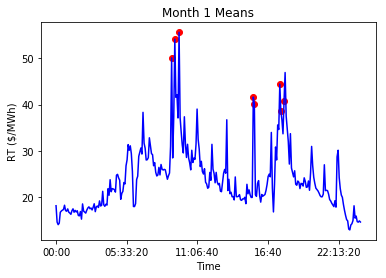

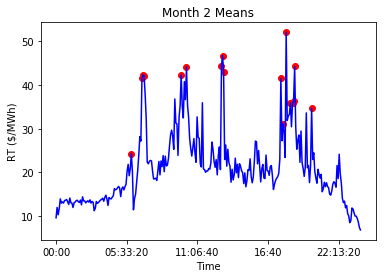

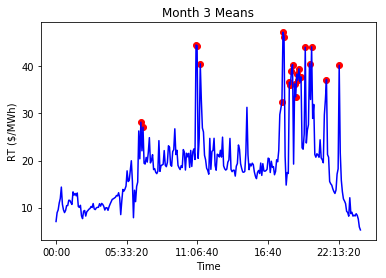

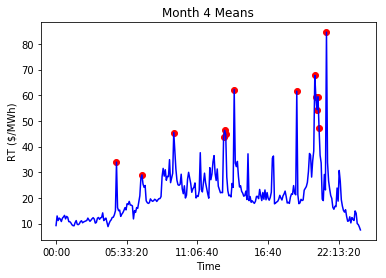

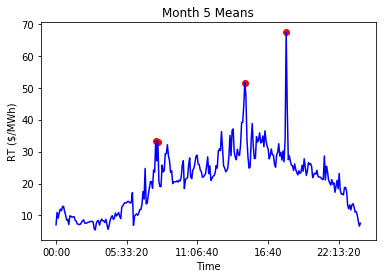

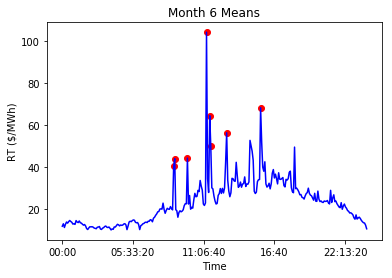

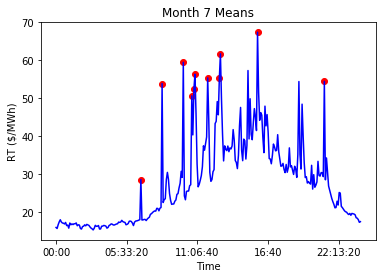

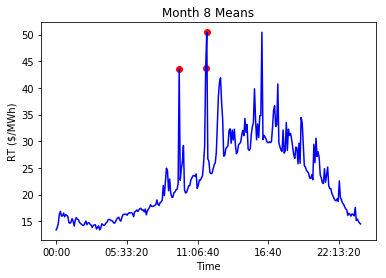

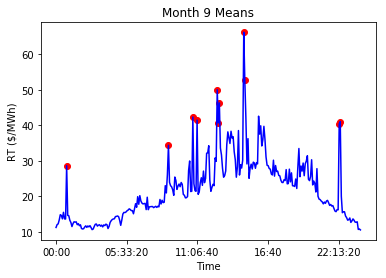

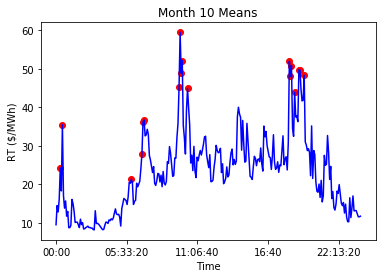

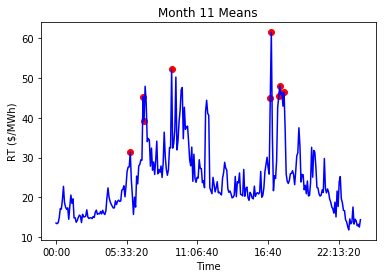

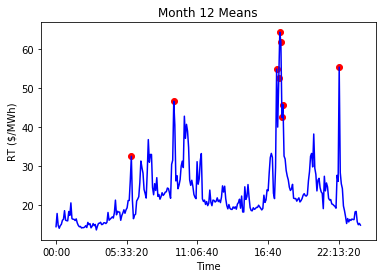

average load slope: 0.029815875845453626 ± 0.10778241361522221


In [47]:
df = DART
load = []
n = 1
for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
        study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std() 

        critical = crit_pts(study)
        critical_df = study.loc[critical]
        result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=critical_df).fit()
        load.append(result10.params.loc['Load'])
        plt.plot(crit_pts2(study)[0],crit_pts2(study)[1],'ro')
        plt.plot(study.index,study['LMP_RT'],'blue')
        plt.title('Month {} Means'.format(j))
        plt.ylabel('RT ($/MWh)')
        plt.xlabel('Time')
        plt.show()

    
print('average load slope: {} \u00B1 {}'.format(np.array(load).mean(), np.array(load).std()))

average SLR load slope: 0.0013340100750759737 ± 0.00021054955760474233
average MLR Load slope: 0.028908622980454893 ± 0.09827612305579404
average MLR Load_Diff slope: -0.0395141239214355 ± 0.2005742142746366
average MLR Previous_Load_Diff slope: 0.12770346985987308 ± 0.3636863038694682
average MLR Previous_Load_Diff_2 slope: -0.13203611209418917 ± 0.300359126659103


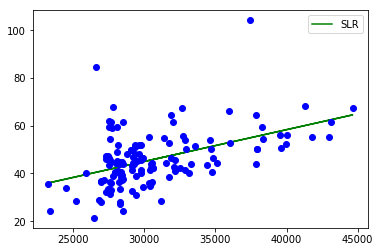

In [32]:
# Training MLR only with peaks

df = DART
load_lists = [[],[],[],[]]
load_params = ['Load', 'Load_Diff', 'Previous_Load_Diff', 'Previous_Load_Diff_2']
n = 1
x = []
y = []
for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
        study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std() 

        critical = crit_pts2(study)[0]
        critical_df = study.loc[critical]
        result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=critical_df).fit()
        for i in range(4):
            load_lists[i].append(result10.params.loc[load_params[i]])
        for value in critical_df['Load'].values:
            x.append(value)
        for value in critical_df['LMP_RT'].values:
            y.append(value)

a, b, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x,a*np.array(x)+b,'green',label='SLR')
#plt.plot(x,np.array(load).mean()*np.array(x)+np.array(intercept).mean(),'orange',label='MLR')
plt.plot(x,y,'bo')
plt.legend()
#print('average MLR load slope: {} \u00B1 {}'.format(np.array(load).mean(), np.array(load).std()))
print('average SLR load slope: {} \u00B1 {}'.format(a, std_err))
for i in range(4):
    print('average MLR {} slope: {} \u00B1 {}'.format(load_params[i], np.array(load_lists[i]).mean(), np.array(load_lists[i]).std()))

NameError: name 'load' is not defined

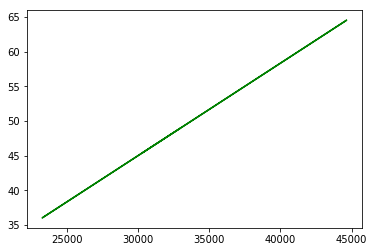

In [33]:
plt.plot(x,a*np.array(x)+b,'green',label='SLR')
plt.plot(x,np.array(load).mean()*np.array(x)+np.array(intercept).mean(),'orange',label='MLR')
plt.plot(x,y,'bo')
plt.legend()

In [31]:
params = {}
for var in result10.params.index:
    params[var] = []
params

{'Intercept': [],
 'LMP_DA': [],
 'RT_std': [],
 'DA_std': [],
 'Load': [],
 'Wind': [],
 'Load_Diff': [],
 'Previous_Load_Diff': [],
 'Previous_Load_Diff_2': [],
 'Previous_RT': [],
 'Previous_RT_2': []}

In [32]:
def means_std_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = [round(np.array(d[key]).mean(),6),round(stats.sem(np.array(d[key])),6)]
    return means_d

average SLR load slope: 0.0013340100750759737 ± 0.00021054955760474233


{'Intercept': [-964.465561, 690.339454],
 'LMP_DA': [-5.036386, 4.431294],
 'RT_std': [0.086383, 0.021484],
 'DA_std': [-9.343853, 6.833684],
 'Load': [0.028909, 0.020492],
 'Wind': [0.051799, 0.040754],
 'Load_Diff': [-0.039514, 0.041823],
 'Previous_Load_Diff': [0.127703, 0.075834],
 'Previous_Load_Diff_2': [-0.132036, 0.062629],
 'Previous_RT': [0.064046, 0.118657],
 'Previous_RT_2': [0.301933, 0.151522]}

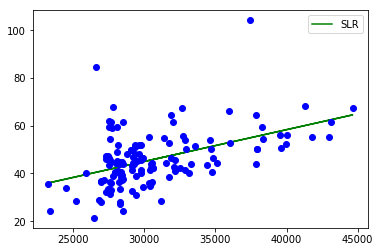

In [34]:
df = DART
x = []
y = []
for j in range(1,13):
    by_month = df[df['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                              'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std() 

    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=critical_df).fit()
    for var in result10.params.index:
        params[var].append(result10.params.loc[var])
    for value in critical_df['Load'].values:
        x.append(value)
    for value in critical_df['LMP_RT'].values:
        y.append(value)

a, b, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x,a*np.array(x)+b,'green',label='SLR')
plt.plot(x,y,'bo')
plt.legend()
print('average SLR load slope: {} \u00B1 {}'.format(a, std_err))
means_std_dict(params)

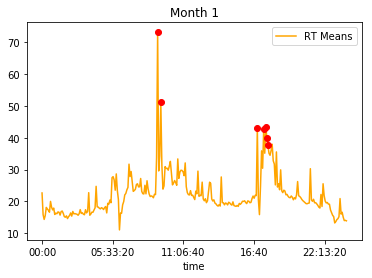

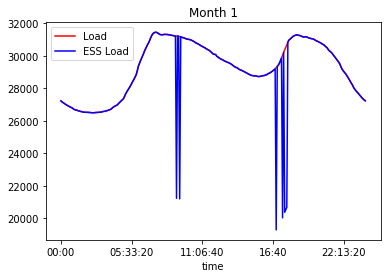

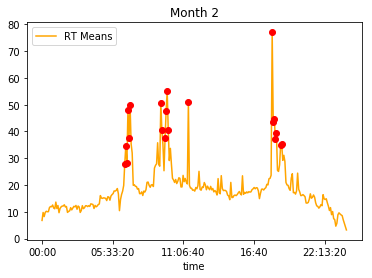

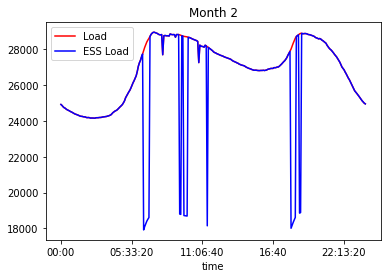

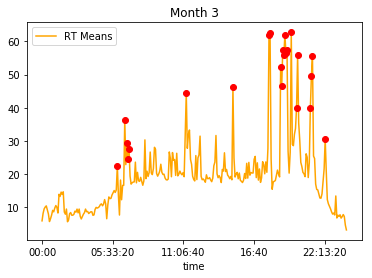

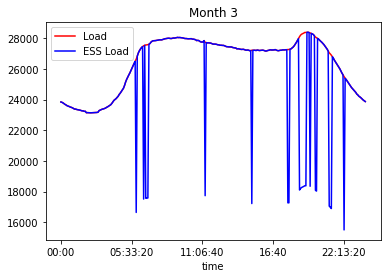

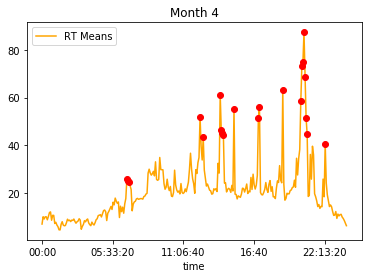

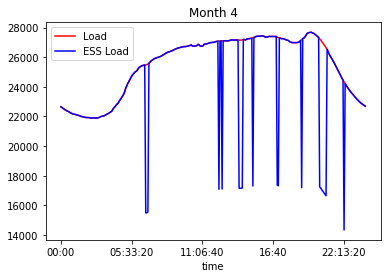

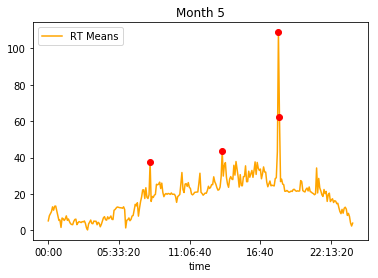

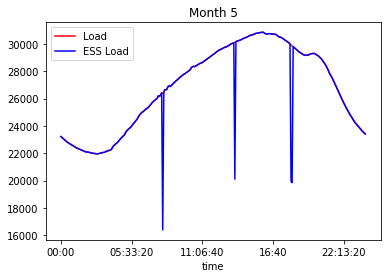

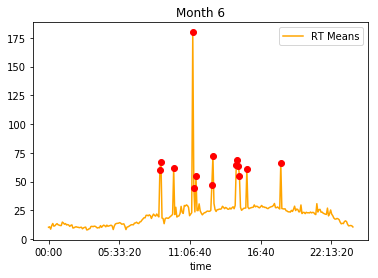

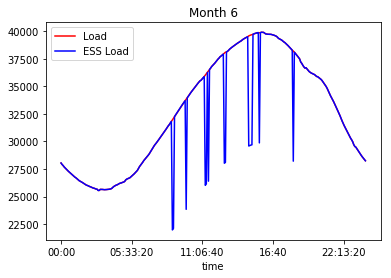

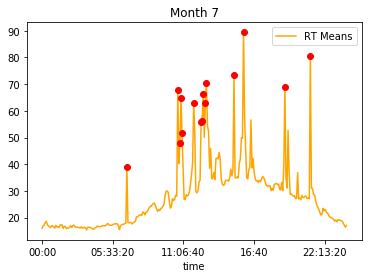

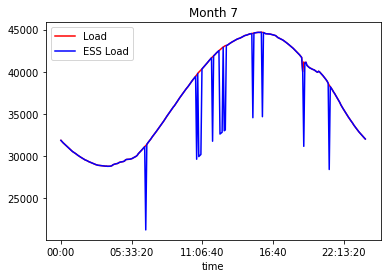

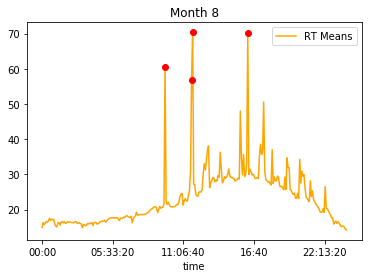

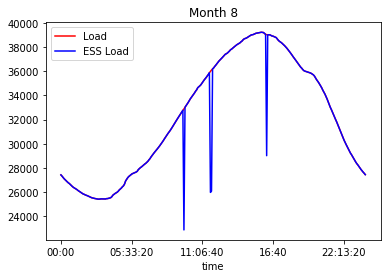

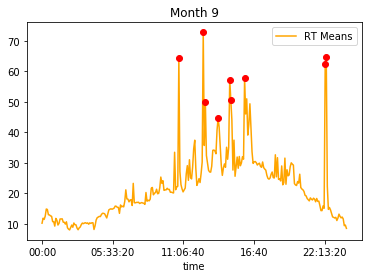

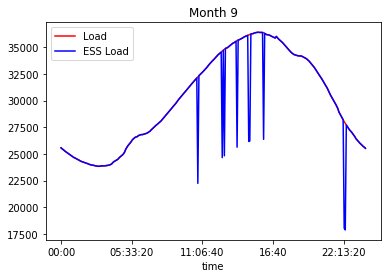

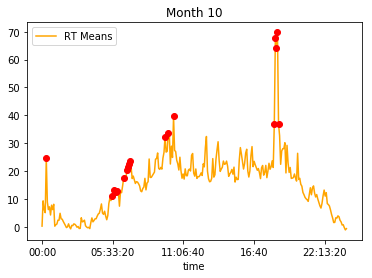

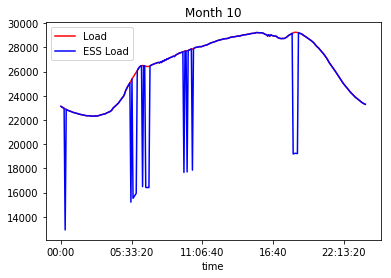

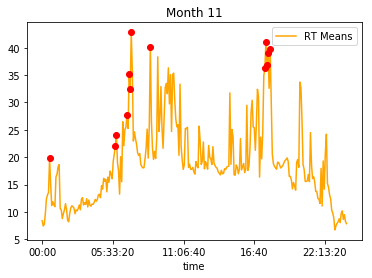

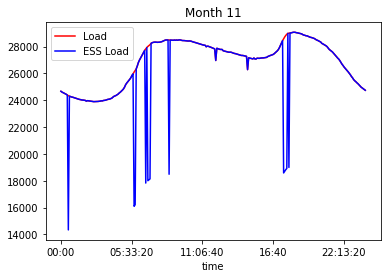

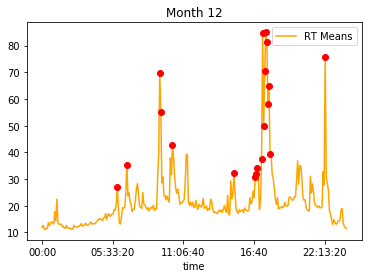

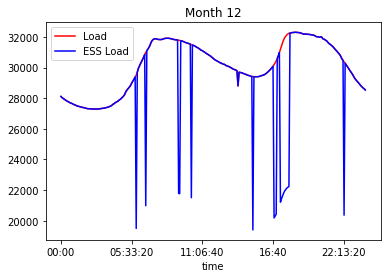

In [37]:
# Reducing loads at critical times

DART2017_ESS = DART2017
ESS_size = 10000
months = []
for month in range(1,13):
    by_month = DART2017[DART2017['Month']==month]
    by_month_ESS = DART2017_ESS[DART2017_ESS['Month']==month]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()
    
    critical = crit_pts2(study)[0]
    for t in critical:
        by_month_ESS.loc[by_month_ESS['Local Time'] == t, 'Load'] -= ESS_size
    
    study2 = by_month_ESS.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()

    months.append(by_month_ESS)
    
    plt.title('Month {}'.format(month))
    plt.plot(study.index, study['LMP_RT'], 'orange', label='RT Means')
    plt.plot(crit_pts2(study)[0],crit_pts2(study)[1],'ro')
    plt.legend()
    plt.show()
    plt.plot(study.index, study['Load'], 'red')
    plt.plot(study2.index, study2['Load'], 'blue', label='ESS Load')
    plt.title('Month {}'.format(month))
    plt.legend()
    plt.show()
    
DART2017_ESS = pd.concat(months)

In [38]:
# Adding previous-interval and moving averages on updated dataset (with reduced load)

DART2017_ESS['Load_Diff'] = DART2017_ESS['Load'] - DART2017_ESS['DA Load']
DART2017_ESS['Spread'] = DART2017_ESS['LMP_DA'] - DART2017_ESS['LMP_RT']
DART2017_ESS = DART2017_ESS.rename(columns={' Wind':'Wind'})

DART2017_ESS_1 = DART2017_ESS.iloc[1:,:]
previous_load_diff = DART2017_ESS['Load_Diff'].iloc[0:-1].values
DART2017_ESS_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2017_ESS['LMP_RT'].iloc[0:-1].values
DART2017_ESS_1['Previous_RT'] = previous_RT
previous_spread = DART2017_ESS['Spread'].iloc[0:-1].values
DART2017_ESS_1['Previous_Spread'] = previous_RT

step = 3
previous_RT = DART2017_ESS_1['LMP_RT'].iloc[0:(DART2017_ESS_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2017_ESS_1['Load_Diff'].iloc[0:(DART2017_ESS_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2017_ESS_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2017_ESS_2 = DART2017_ESS_1.iloc[step:,:]
DART2017_ESS_2['Previous_RT_2'] = previous_means_RT
DART2017_ESS_2['Previous_Load_Diff_2'] = previous_means_load

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

0.022623


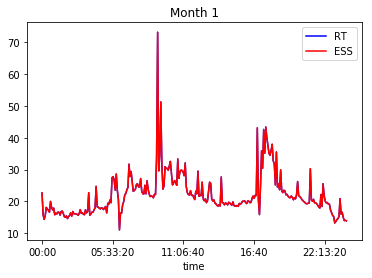

0.065426


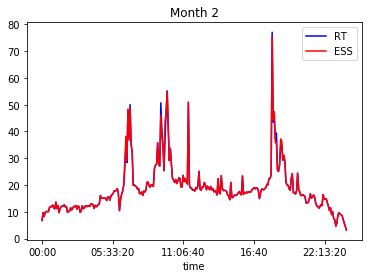

-0.001514


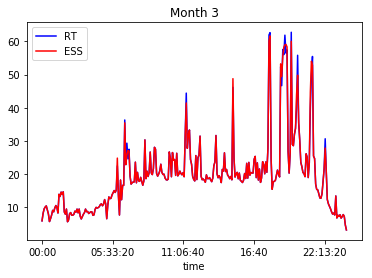

-0.040447


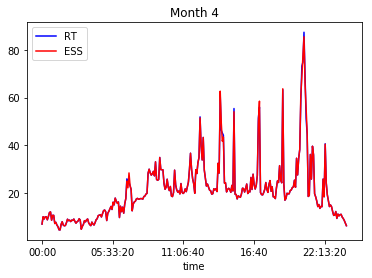

-0.007574


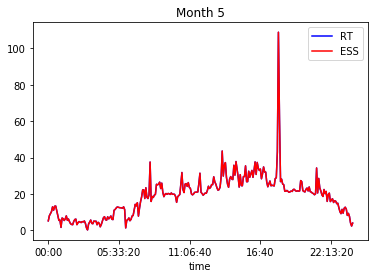

-0.001094


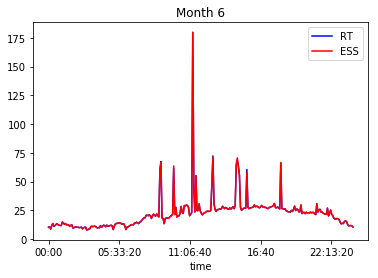

0.001607


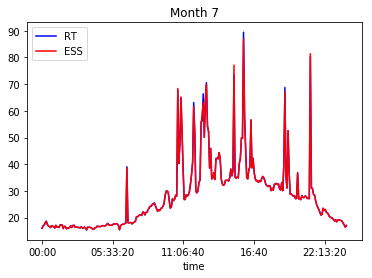

-0.002068


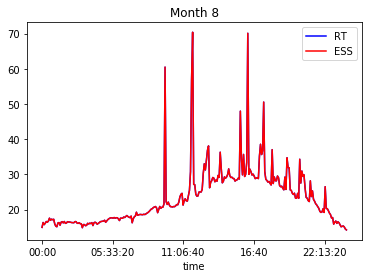

-0.023672


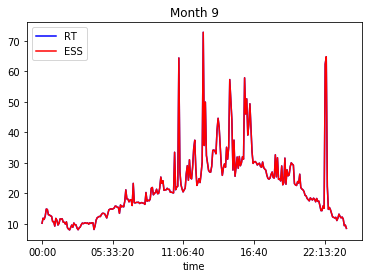

-0.005502


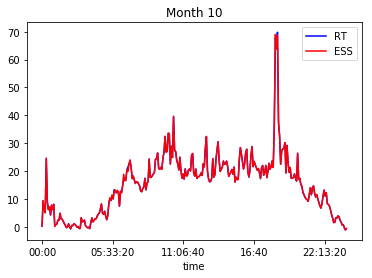

-0.040424


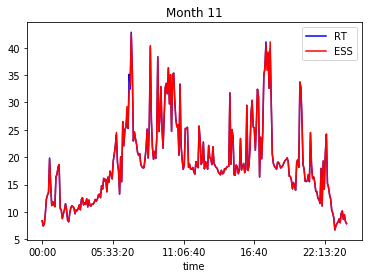

-0.019337


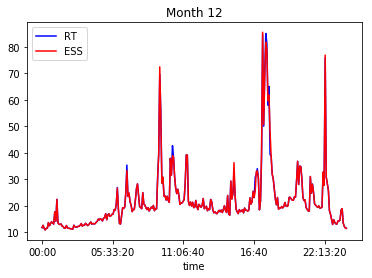

0.164678

In [39]:
# Estimating price with peak-only MLR

df = DART2017_ESS_2
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                              'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        

    study['ESS RT'] = study['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    result_peak = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=critical_df).fit()
    print(round(result_peak.params.loc['Load'],6))
    for hour in study.index:
        if hour in critical:
            study['ESS RT'].loc[hour] = (
                                    study['Previous_RT_2'].loc[hour]*result_peak.params[10] +  
                                    study['Previous_RT'].loc[hour]*result_peak.params[9] +
                                    study['Previous_Load_Diff_2'].loc[hour]*result_peak.params[8] + 
                                    study['Previous_Load_Diff'].loc[hour]*result_peak.params[7] + 
                                    study['Load_Diff'].loc[hour]*result_peak.params[6] + 
                                    study['Wind'].loc[hour]*result_peak.params[5] + 
                                    study['Load'].loc[hour]*result_peak.params[4] + 
                                    study['DA_std'].loc[hour]*result_peak.params[3] + 
                                    study['RT_std'].loc[hour]*result_peak.params[2] + 
                                    study['LMP_DA'].loc[hour]*result_peak.params[1] + 
                                    result_peak.params[0])
            p_err = 100*(study['ESS RT'].loc[hour] - study['LMP_RT'].loc[hour])/study['LMP_RT'].loc[hour]
            total_err.append(p_err)
    plt.plot(study.index, study['LMP_RT'], 'blue', label='RT')
    plt.plot(study.index, study['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

Too many parameters and had the wrong training dynamic. Corrected below.

In [60]:
# Only Load

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
PE_8_list = []
errors = 0

df = DART

slopes_10 = {}
slopes_8 = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (8)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind 
                                            + Previous_RT + Previous_RT_2""", data=cluster).fit()                
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
                    test_data_copy['fitted RT (8)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[7] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result8.params[6] +
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        PE_8_list.append(pe(test_data_copy['fitted RT (8)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)
PE_8_array = np.array(PE_8_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('7 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('# of errors: {}'.format(errors))

100.0%
MAPE ± std
10 predictors: 9.328849118695445 ± 4.325834955930553
7 predictors: 9.332424065939898 ± 3.9777536239689866
# of errors: 0


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


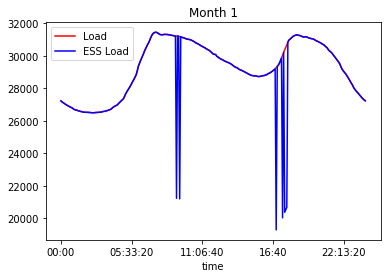

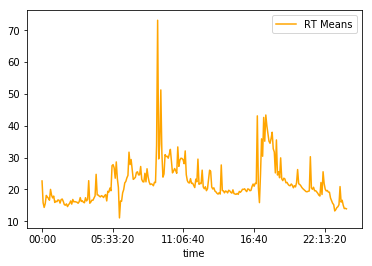

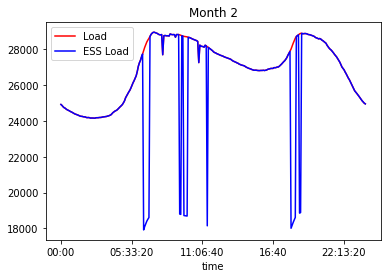

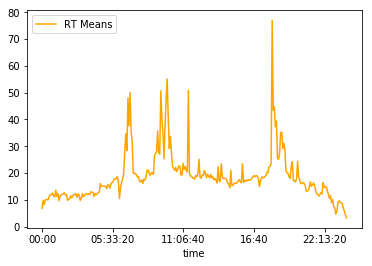

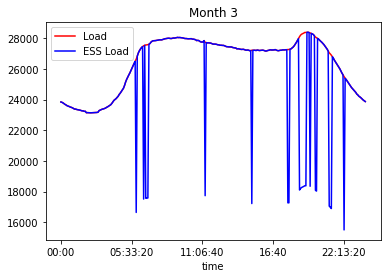

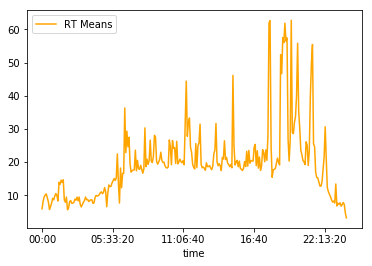

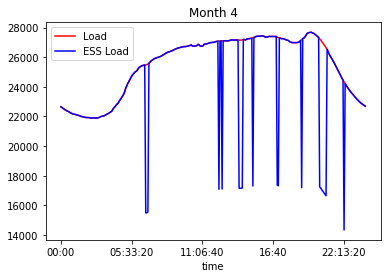

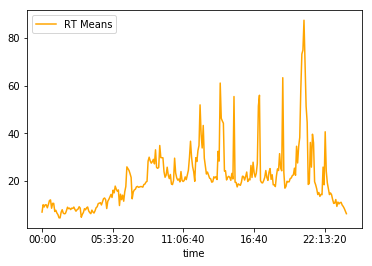

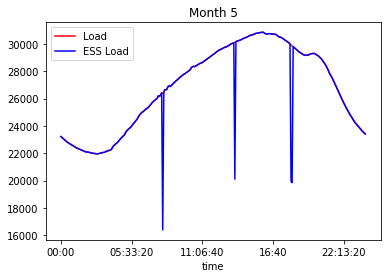

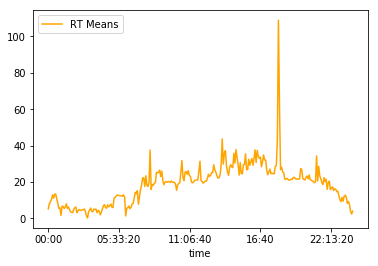

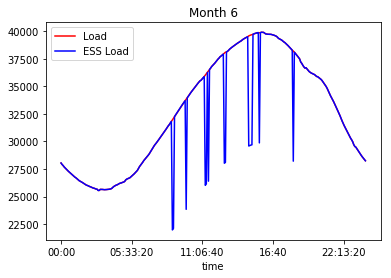

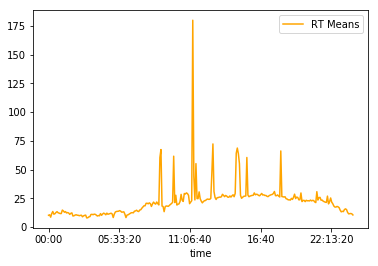

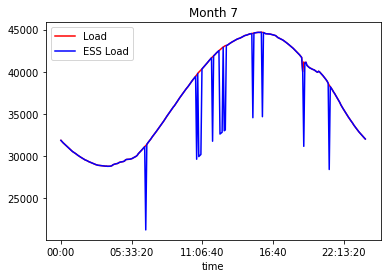

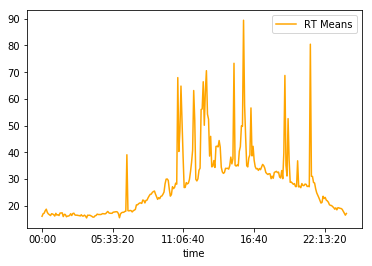

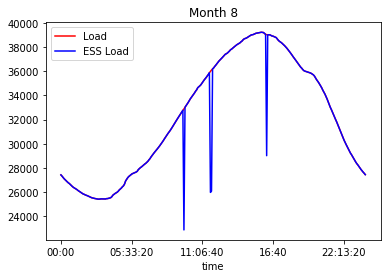

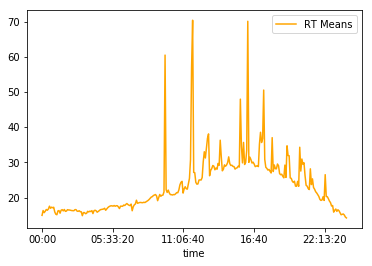

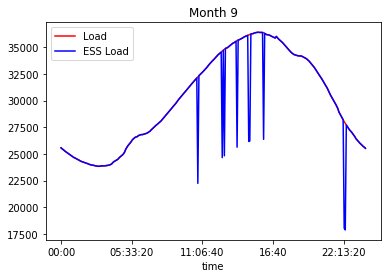

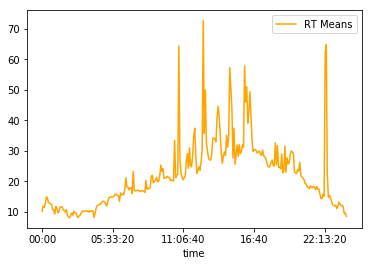

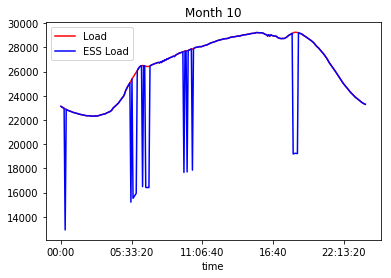

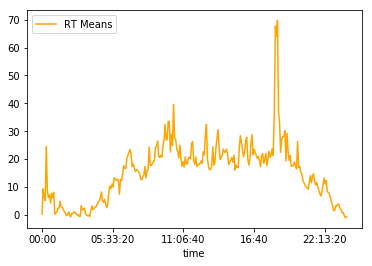

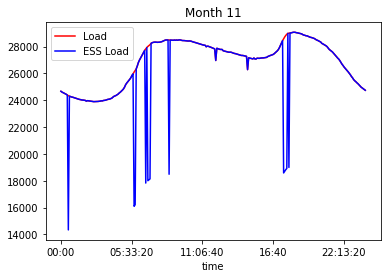

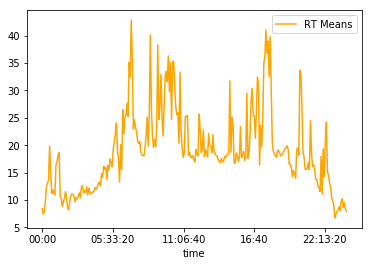

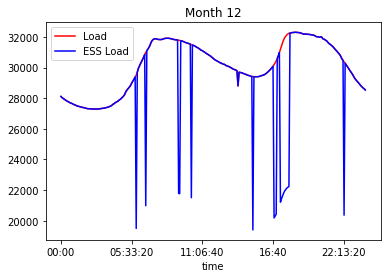

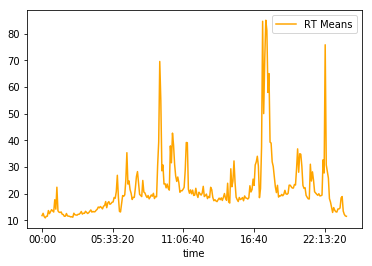

In [35]:
DART2017_ESS = DART2017
ESS_size = 10000
months = []
for month in range(1,13):
    by_month = DART2017[DART2017['Month']==month]
    by_month_ESS = DART2017_ESS[DART2017_ESS['Month']==month]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()
    
    critical = crit_pts2(study)[0]
    for t in critical:
        by_month_ESS.loc[by_month_ESS['Local Time'] == t, 'Load'] -= ESS_size
    
    study2 = by_month_ESS.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()

    months.append(by_month_ESS)
    
    plt.plot(study.index, study['Load'], 'red')
    plt.plot(study2.index, study2['Load'], 'blue', label='ESS Load')
    plt.title('Month {}'.format(month))
    plt.legend()
    plt.show()
    plt.plot(study.index, study['LMP_RT'], 'orange', label='RT Means')
    plt.legend()
    plt.show()

DART2017_ESS = pd.concat(months)

In [40]:
DART2017_ESS = DART2017_ESS.rename(columns={' Wind':'Wind'})

DART2017_ESS_1 = DART2017_ESS.iloc[1:,:]
previous_RT = DART2017_ESS['LMP_RT'].iloc[0:-1].values
DART2017_ESS_1['Previous_RT'] = previous_RT

step = 3
previous_RT = DART2017_ESS_1['LMP_RT'].iloc[0:(DART2017_ESS_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
for i in range(DART2017_ESS_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
DART2017_ESS_2 = DART2017_ESS_1.iloc[step:,:]
DART2017_ESS_2['Previous_RT_2'] = previous_means_RT


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


0.003899
09:05:00
09:20:00
16:55:00
17:25:00
17:35:00
17:40:00
17:45:00


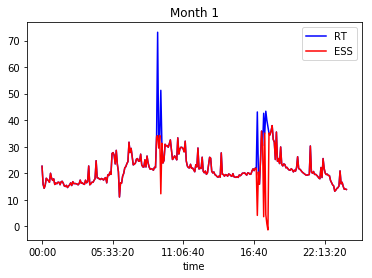

0.02268
06:30:00
06:35:00
06:40:00
06:45:00
06:50:00
06:55:00
09:20:00
09:25:00
09:40:00
09:45:00
09:50:00
09:55:00
11:30:00
18:05:00
18:10:00
18:15:00
18:20:00
18:25:00
18:45:00
18:50:00


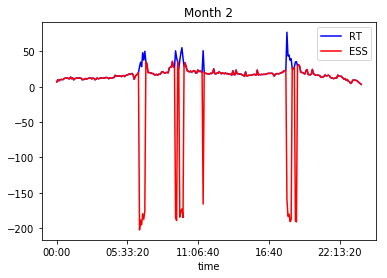

0.000975
05:55:00
06:30:00
06:40:00
06:45:00
06:50:00
11:20:00
15:00:00
17:50:00
17:55:00
18:45:00
18:50:00
18:55:00
19:00:00
19:05:00
19:10:00
19:15:00
19:35:00
20:00:00
20:05:00
21:05:00
21:10:00
21:15:00
22:15:00


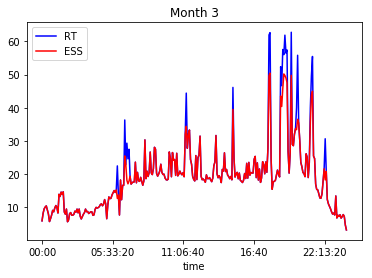

-0.005746
06:40:00
06:45:00
06:50:00
12:25:00
12:40:00
14:00:00
14:05:00
14:10:00
14:15:00
15:05:00
17:00:00
17:05:00
18:55:00
20:20:00
20:25:00
20:30:00
20:35:00
20:40:00
20:45:00
20:50:00
22:15:00


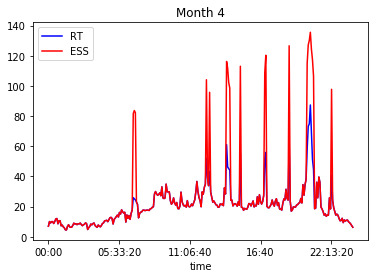

0.002
08:00:00
13:40:00
18:05:00
18:10:00


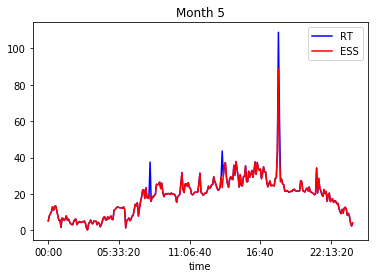

0.000991
08:45:00
08:50:00
09:50:00
11:20:00
11:25:00
11:35:00
12:50:00
12:55:00
14:45:00
14:50:00
14:55:00
15:00:00
15:35:00
18:15:00


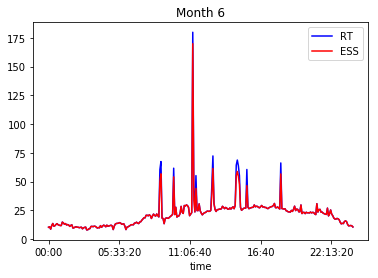

0.003077
06:40:00
10:40:00
10:50:00
10:55:00
11:00:00
11:55:00
12:30:00
12:35:00
12:40:00
12:50:00
12:55:00
15:05:00
15:50:00
19:05:00
21:05:00


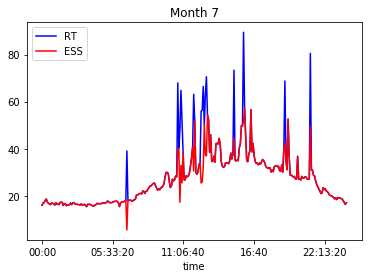

-0.000253
09:40:00
11:45:00
11:50:00
16:10:00


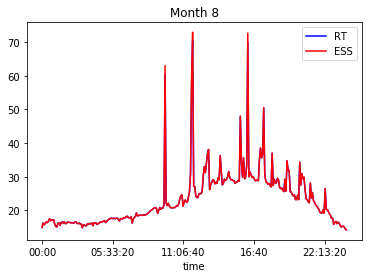

-0.002658
10:45:00
12:40:00
12:50:00
13:50:00
14:45:00
14:50:00
15:55:00
22:15:00
22:20:00


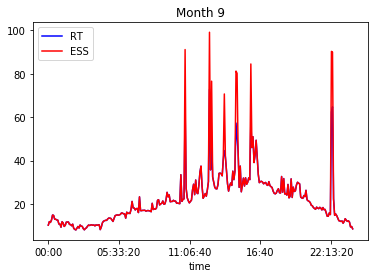

-0.003831
00:20:00
05:30:00
05:40:00
05:45:00
05:50:00
05:55:00
06:25:00
06:40:00
06:45:00
06:50:00
06:55:00
09:40:00
09:55:00
10:20:00
18:15:00
18:20:00
18:25:00
18:30:00
18:35:00


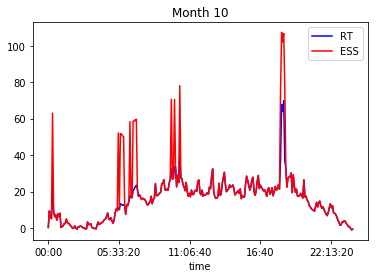

0.001056
00:35:00
05:45:00
05:50:00
06:40:00
06:50:00
06:55:00
07:00:00
08:30:00
17:30:00
17:35:00
17:40:00
17:45:00
17:55:00


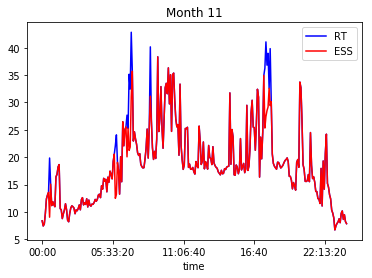

0.00225
05:55:00
06:40:00
09:15:00
09:20:00
10:15:00
15:05:00
16:45:00
16:50:00
16:55:00
17:15:00
17:20:00
17:25:00
17:30:00
17:35:00
17:40:00
17:45:00
17:50:00
17:55:00
22:15:00


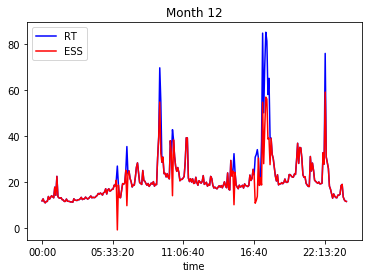

-49.367659

In [41]:
# Estimating price with peak-only MLR (MLR with fewer parameters)

df = DART2017_2
df_ESS = DART2017_ESS_2
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]
    by_month2 = df_ESS[df_ESS['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        
    study['ESS RT'] = study['LMP_RT']
    
    study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std()        
    study2['ESS RT'] = study2['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    result_peak = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind +
                                        Previous_RT + Previous_RT_2""", data=critical_df).fit()
    print(round(result_peak.params.loc['Load'],6))
    for hour in critical:
        print(hour)
    for hour in critical:
        study2['ESS RT'].loc[hour] = (
                                study2['Previous_RT_2'].loc[hour]*result_peak.params[7] +  
                                study2['Previous_RT'].loc[hour]*result_peak.params[6] +
                                study2['Wind'].loc[hour]*result_peak.params[5] + 
                                study2['Load'].loc[hour]*result_peak.params[4] + 
                                study2['DA_std'].loc[hour]*result_peak.params[3] + 
                                study2['RT_std'].loc[hour]*result_peak.params[2] + 
                                study2['LMP_DA'].loc[hour]*result_peak.params[1] + 
                                result_peak.params[0])
        p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
        total_err.append(p_err)
    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT')
    plt.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

Training peak-only sometimes gives negative slopes, which compromises the model

0.001354


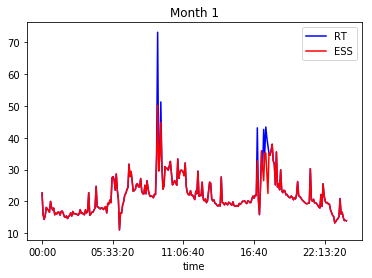

0.002927


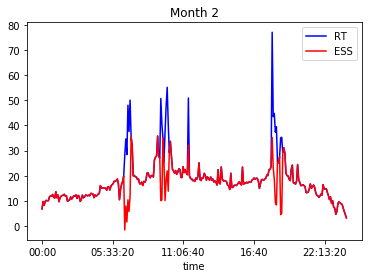

0.002143


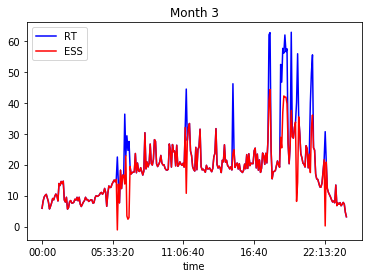

0.001956


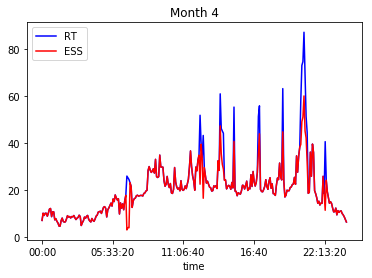

0.001587


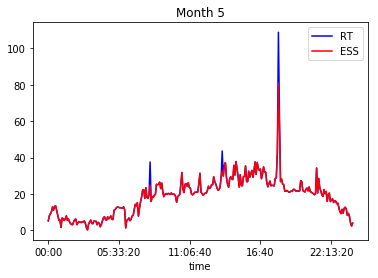

0.001244


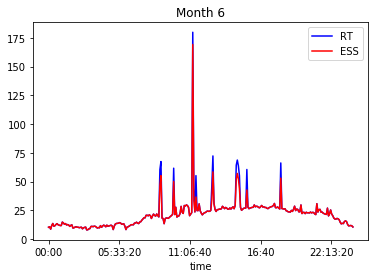

0.000882


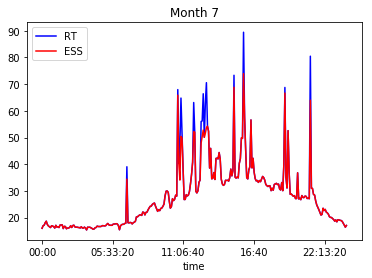

0.000642


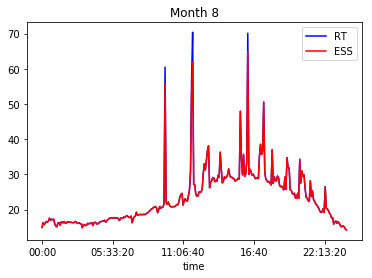

0.001579


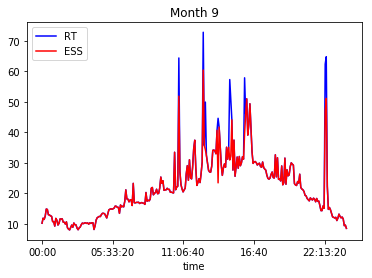

0.002447


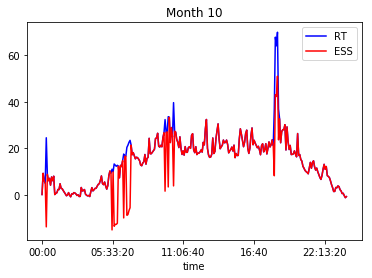

0.003026


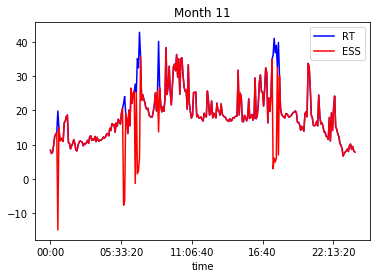

0.002305


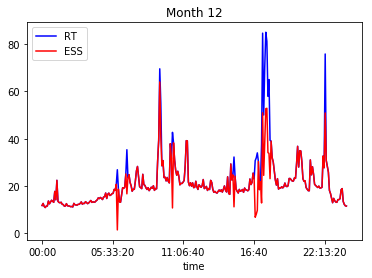

-55.801862

In [42]:
# Estimating price with single-cluster, all-day MLR

df = DART2017_2
df_ESS = DART2017_ESS_2
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]
    by_month2 = df_ESS[df_ESS['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        
    study['ESS RT'] = study['LMP_RT']
    
    study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std()        
    study2['ESS RT'] = study2['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]

            
    result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind +
                                        Previous_RT + Previous_RT_2""", data=study).fit()
    print(round(result.params.loc['Load'],6))
    for hour in critical:
        study2['ESS RT'].loc[hour] = (
                                study2['Previous_RT_2'].loc[hour]*result.params[7] +  
                                study2['Previous_RT'].loc[hour]*result.params[6] +
                                study2['Wind'].loc[hour]*result.params[5] + 
                                study2['Load'].loc[hour]*result.params[4] + 
                                study2['DA_std'].loc[hour]*result.params[3] + 
                                study2['RT_std'].loc[hour]*result.params[2] + 
                                study2['LMP_DA'].loc[hour]*result.params[1] + 
                                result.params[0])
        p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
        total_err.append(p_err)
    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT')
    plt.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

-0.000485
0.002134
0.001903
-0.000279


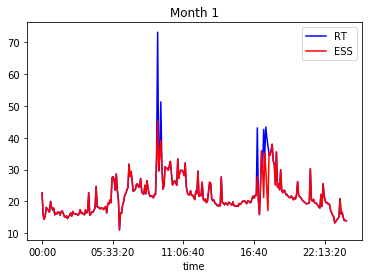

0.000597
0.001382
0.004091
0.003259


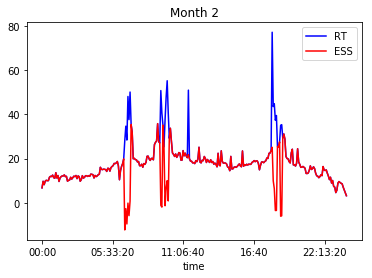

-0.001848
0.002598
0.003518
0.012807


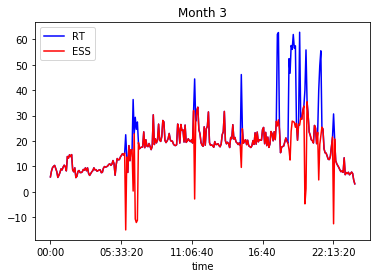

-0.001576
0.004399
0.000752
0.000765


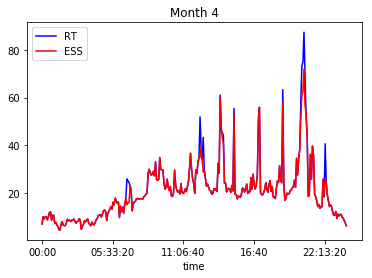

0.000808
0.001495
0.001082
0.006346


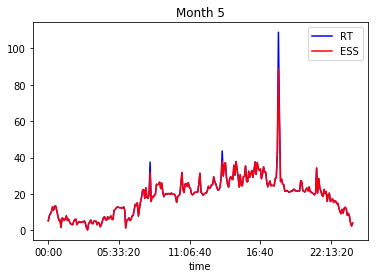

0.000554
0.001992
0.001243
0.003042


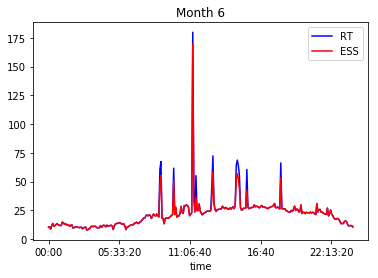

8.7e-05
0.00483
0.001218
0.000444


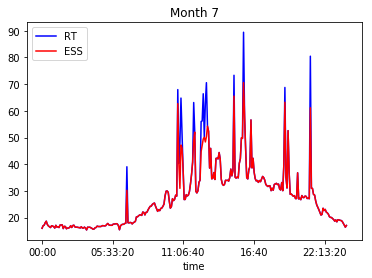

-0.000896
0.001766
0.000962
-0.001471


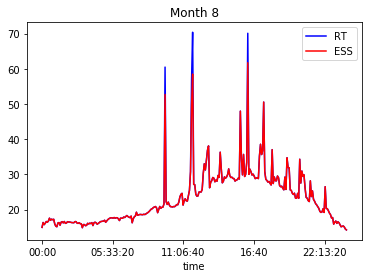

0.000937
0.003018
0.001573
0.001341


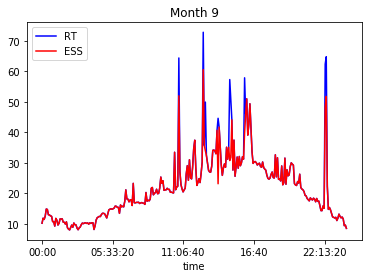

0.000127
0.005162
0.001197
0.004331


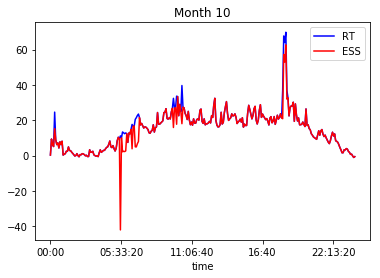

-0.006643
0.004873
0.003877
-0.00778


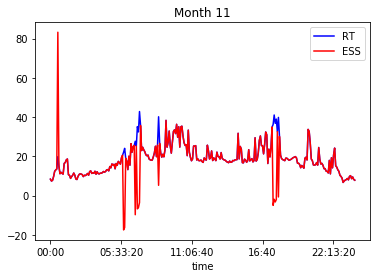

0.0036
-0.002512
0.003745
-0.00017


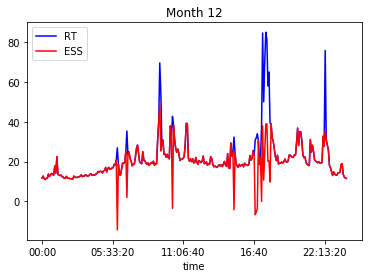

-58.203239

In [55]:
# Estimating price with multi-cluster, all-day MLR

df = DART2017_2
df_ESS = DART2017_ESS_2
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]
    by_month2 = df_ESS[df_ESS['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        
    study['ESS RT'] = study['LMP_RT']
    
    study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std()        
    study2['ESS RT'] = study2['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind +
                                        Previous_RT + Previous_RT_2""", data=study.loc[cluster.index]).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[7] +  
                                        study2['Previous_RT'].loc[hour]*result.params[6] +
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        study2['Load'].loc[hour]*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            
    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT')
    plt.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

In [58]:
# Finding slopes for 7-variable MLR

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
errors = 0

df = DART2017_2

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind 
                                            + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for var in result10.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result10.params.loc[var])
                    else:
                        slopes[var].append(result10.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[7] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[6] +
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
                
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('7 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))
means_std_dict(slopes)

100.0%
MAPE ± std
7 predictors: 52.0365854099445 ± 343.8206291854864
# of errors: 0


{'Intercept': [12.164714, 17.403621],
 'LMP_DA': [-0.23933, 0.14492],
 'RT_std': [0.057681, 0.016763],
 'DA_std': [-0.403034, 0.256076],
 'Load': [0.000428, 0.000561],
 'Wind': [-0.00123, 0.000223],
 'Previous_RT': [0.238152, 0.019656],
 'Previous_RT_2': [0.104932, 0.022918]}

In [53]:
avg_slopes = means_std_dict(slopes)

7.3e-05
0.002207
0.002331
0.001593


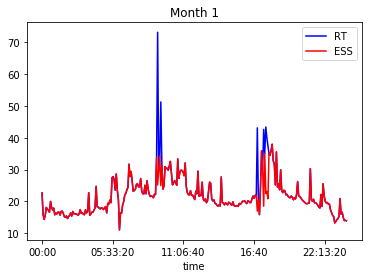

0.001254
0.001901
0.003247
0.002838


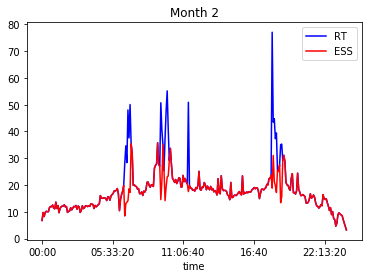

0.001526
0.00315
0.003531
0.010729


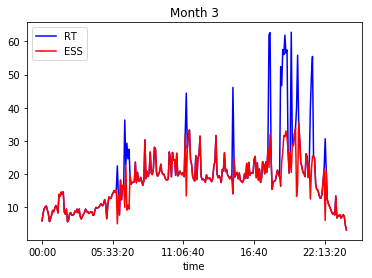

0.000207
0.00429
-0.000709
0.004614


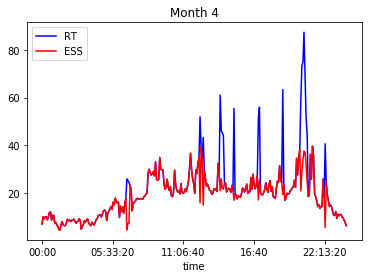

0.001104
0.001604
0.002175
-0.001472


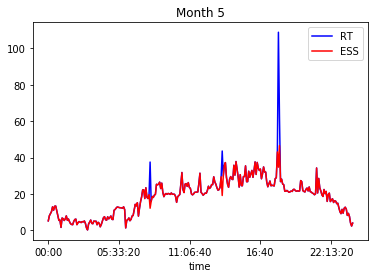

0.000765
0.00602
0.001166
0.003842


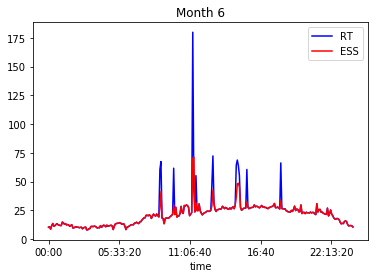

0.000389
0.001495
0.002383
0.000804


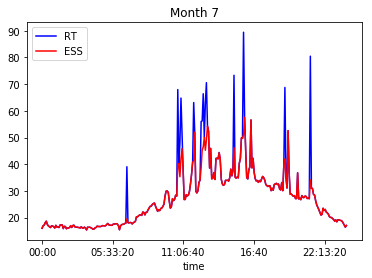

0.000218
0.001169
0.001277
0.001538


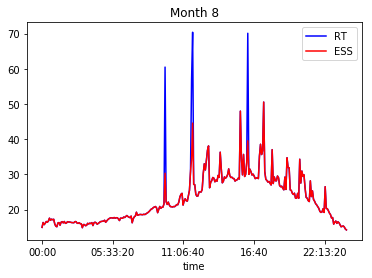

0.000559
-0.000333
0.001865
0.00189


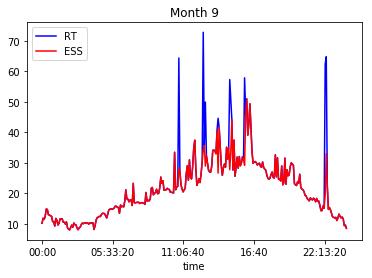

0.00216
0.00221
-0.00021
0.00387


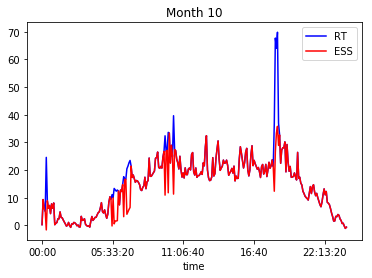

0.000275
-0.01615
0.003532
0.000374


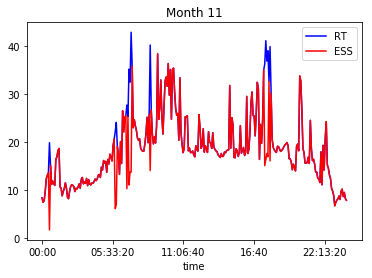

0.003806
-0.001432
0.00401
-0.000144


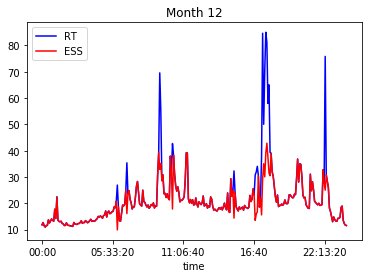

-55.08679

In [54]:
# Estimating price with multi-cluster, all-day MLR (previously-calculated slopes)

df = DART2017_2
df_ESS = DART2017_ESS_2
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]
    by_month2 = df_ESS[df_ESS['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        
    study['ESS RT'] = study['LMP_RT']
    
    study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std()        
    study2['ESS RT'] = study2['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind +
                                        Previous_RT + Previous_RT_2""", data=study.loc[cluster.index]).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*avg_slopes['Previous_RT_2'][0] +  
                                        study2['Previous_RT'].loc[hour]*avg_slopes['Previous_RT'][0] +
                                        study2['Wind'].loc[hour]*avg_slopes['Wind'][0] + 
                                        study2['Load'].loc[hour]*avg_slopes['Load'][0] + 
                                        study2['DA_std'].loc[hour]*avg_slopes['DA_std'][0] + 
                                        study2['RT_std'].loc[hour]*avg_slopes['RT_std'][0] + 
                                        study2['LMP_DA'].loc[hour]*avg_slopes['LMP_DA'][0] + 
                                        avg_slopes['Intercept'][0])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            
    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT')
    plt.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

In [55]:
# Reducing to 1 df

DART2017_2['Load_ESS'] = DART2017_ESS_2['Load']

-0.000183
0.001792
0.001379
0.001773


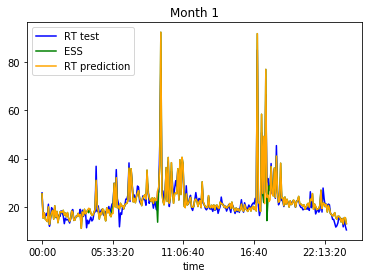

0.000459
0.000734
0.002511
0.001917


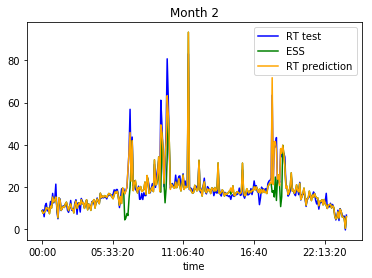

0.000298
-0.001453
0.000394
0.004335


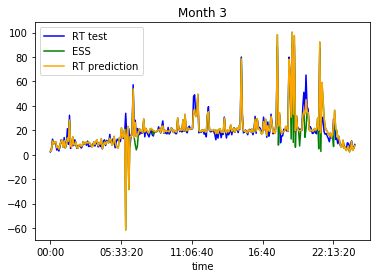

0.001347
0.003132
-0.000439
0.005399


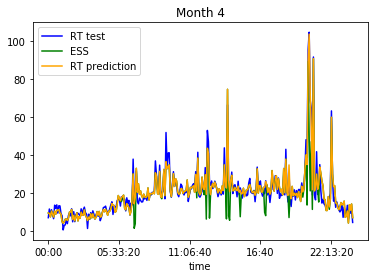

0.000828
0.002263
0.000811
0.001041


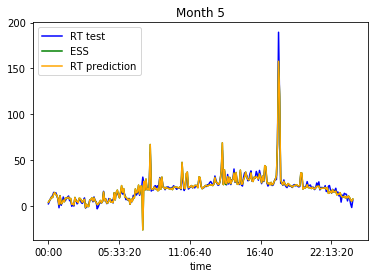

0.000163
0.005305
0.000294
0.001483


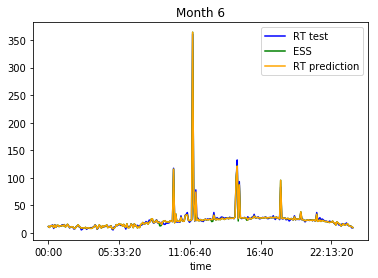

8.9e-05
0.001286
0.00131
0.000958


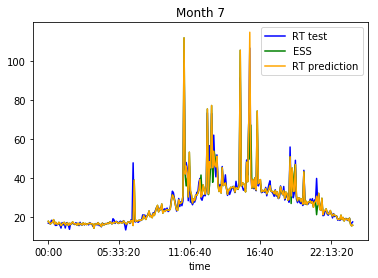

0.000227
0.000276
0.000962
0.000897


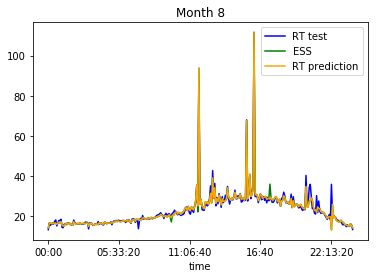

0.000456
0.000355
0.001226
0.000249


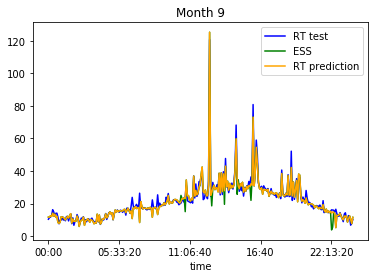

0.00215
2.2e-05
0.000777
0.002408


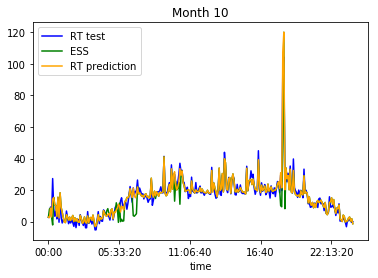

0.000883
0.003428
0.001713
0.001262


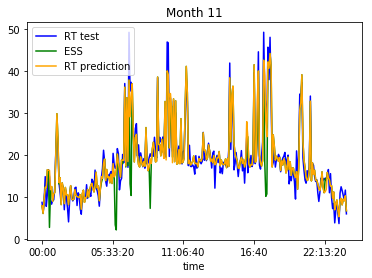

0.000704
0.001194
0.001724
0.001098


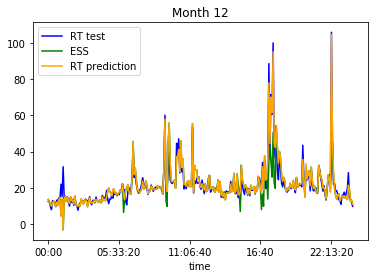

22.505359293655065


-38.562383

In [56]:
# Estimating price with multi-cluster, all-day MLR (previously-calculated slopes) + testing

df = DART2017_2
total_err = []
pe_list = []

for j in range(1,13):
    by_month = df[df['Month']==j]
    train, test = train_test_split(by_month, test_size=0.5)

    study = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2']].mean()
    study['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
    
    study2 = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT', 'Previous_RT_2', 'Load_ESS']].mean()
    study2['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = test.groupby('Local Time')['LMP_DA'].std()        
    study2['pred RT'] = np.zeros(study2.shape[0])
    study2['ESS RT'] = np.zeros(study2.shape[0])
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind +
                                        Previous_RT + Previous_RT_2""", data=cluster).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            study2['pred RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[7] +  
                                        study2['Previous_RT'].loc[hour]*result.params[6] +
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        study2['Load'].loc[hour]*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*avg_slopes['Previous_RT_2'][0] +  
                                        study2['Previous_RT'].loc[hour]*avg_slopes['Previous_RT'][0] +
                                        study2['Wind'].loc[hour]*avg_slopes['Wind'][0] + 
                                        study2['Load_ESS'].loc[hour]*avg_slopes['Load'][0] + 
                                        study2['DA_std'].loc[hour]*avg_slopes['DA_std'][0] + 
                                        study2['RT_std'].loc[hour]*avg_slopes['RT_std'][0] + 
                                        study2['LMP_DA'].loc[hour]*avg_slopes['LMP_DA'][0] + 
                                        avg_slopes['Intercept'][0])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            else:
                study2['ESS RT'].loc[hour] = study2['pred RT'].loc[hour]
                
    pe_list.append(pe(study2['pred RT'], study2['LMP_RT']).mean())

    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT test')
    plt.plot(study2.index, study2['ESS RT'], 'green', label='ESS')
    plt.plot(study2.index, study2['pred RT'], 'orange', label='RT prediction')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()

print(np.array(pe_list).mean())
round(np.array(total_err).mean(),6)

Shift focus to demand sensitivity as output.

Using 10 parameters doesn't seem necessary.

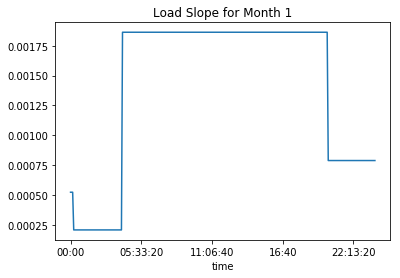

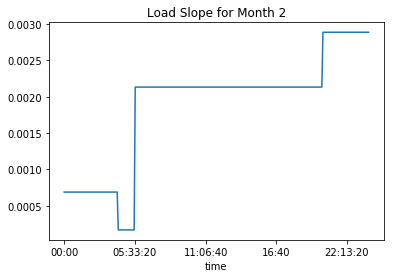

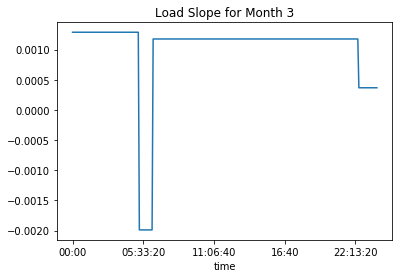

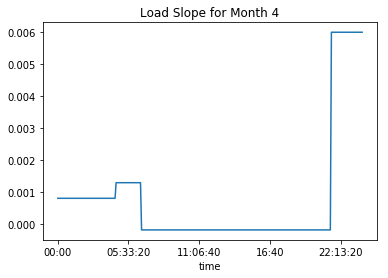

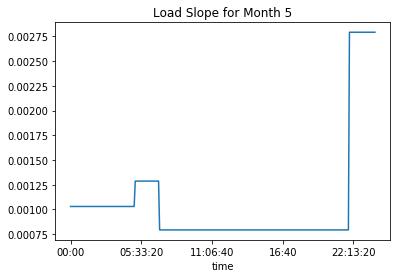

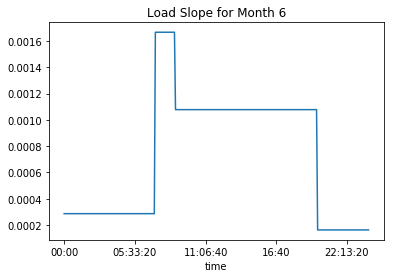

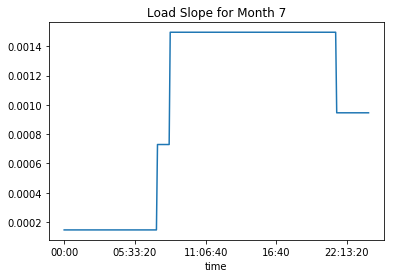

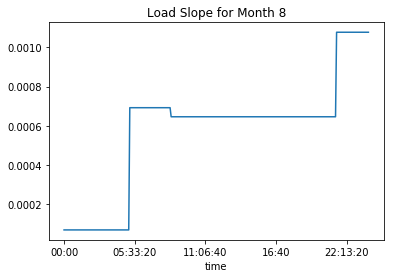

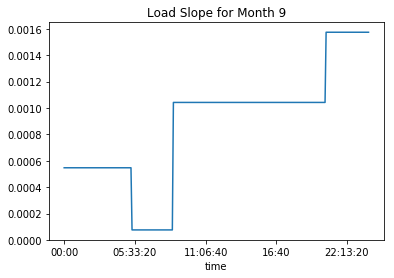

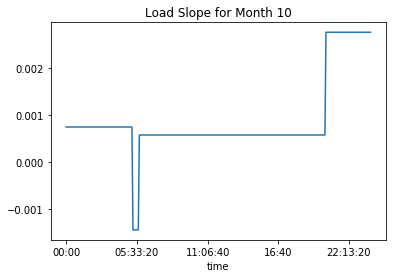

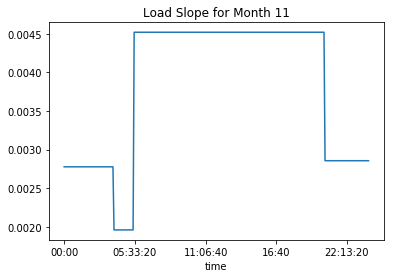

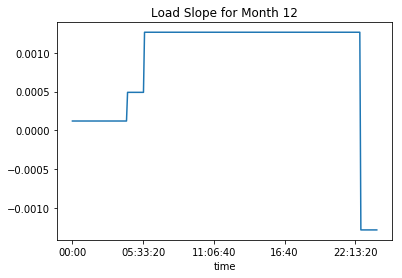

100.0%
MAPE ± std
7 predictors: 7.269404551911884 ± 2.9810893826726588
# of errors: 0


In [69]:
# Only Load

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
PE_8_list = []
errors = 0

df = DART

slopes_10 = {}
slopes_8 = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (8)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        load_slopes = []
        for cluster in branch_dfs:
            try:
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind 
                                            + Previous_RT + Previous_RT_2""", data=cluster).fit()  
                for hour in cluster.index:
                    load_slopes.append(result8.params.loc['Load'])
                    test_data_copy['fitted RT (8)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[7] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result8.params[6] +
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_8_list.append(pe(test_data_copy['fitted RT (8)'], test_data_copy['LMP_RT']).mean())
        if i == 0:
            plt.title('Load Slope for Month {}'.format(j))
            plt.plot(test_data.index, np.array(load_slopes))
            plt.show()
            
    print(f'\r{100*(i+1)/n}%',end='')

PE_8_array = np.array(PE_8_list)

print('\nMAPE \u00B1 std')
print('7 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('# of errors: {}'.format(errors))